In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from IPython.display import Image
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, plot_precision_recall_curve, plot_roc_curve,precision_recall_curve
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from itertools import cycle
from sklearn.multiclass import OneVsOneClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn import svm
import pydotplus
from plotly.offline import plot as plotoff

plt.rc('xtick', color='k', labelsize='medium', direction='in')
plt.rc('xtick.major', size=8, pad=12)
plt.rc('xtick.minor', size=8, pad=12)

plt.rc('ytick', color='k', labelsize='medium', direction='in')
plt.rc('ytick.major', size=8, pad=12)
plt.rc('ytick.minor', size=8, pad=12)

In [6]:
import scipy.stats as stats 
import math


Highest likelihood is for \mu and \sigma : 2.0 0.5


<ipython-input-7-0156c3079be8>:30: MatplotlibDeprecationWarning:

Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.



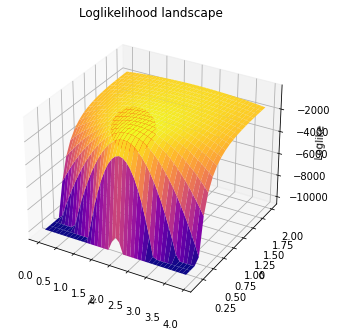

In [7]:
X=np.random.randn(800)*0.5+2

mu=np.arange(0,4,0.1) # from 0 to 4 by increments of 0.1
sigma=np.arange(0.1,2.1,0.1) # from 0.1 to 2.1 by increments of 0.1

mu,sigma=np.meshgrid(mu,sigma) # this useful function combines all possibles values for mu and sigma
def loglike_func(X,mu,sigma):
    """returns a list of the loglikelihoods of mus and sigmas given data X"""
    ll = []
    for i in range(len(mu)):
        ll.append( sum(np.log(stats.norm.pdf(X,mu[i],sigma[i]))) )
        if math.isnan(ll[-1]) or ll[-1] < -10000: 
            ll[-1] = -10000 # we verify that no numerical error gave us an NaN or very small log value
    return ll

# we compute the log-likelihood for all tested parameters values 
zs=np.array(
    loglike_func(X,np.ravel(mu),np.ravel(sigma))
) 
loglike=zs.reshape(mu.shape)

bestMu = np.ravel(mu)[np.argmax(zs)]
bestSigma = np.ravel(sigma)[np.argmax(zs)]

# make a 3D figure of our loglikelihood landscape
from mpl_toolkits.mplot3d import Axes3D 
print(r'Highest likelihood is for \mu and \sigma :',bestMu,bestSigma)

fig = plt.figure() 
ax = Axes3D(fig)
ax.plot_surface(mu,sigma,loglike,cmap='plasma') 
ax.scatter(bestMu,bestSigma,max(zs),s=2000,c='r') # put a dot at the ML value
ax.set_xlabel('$\mu$')
ax.set_ylabel('$\sigma$')
ax.set_zlabel('Loglike')
plt.title("Loglikelihood landscape")

plt.show()

In [133]:
X=np.random.randn(800)*0.5+2

mu=np.arange(0,4,0.1) # from 0 to 4 by increments of 0.1
sigma=np.arange(0.1,2.1,0.1) # from 0.1 to 2.1 by increments of 0.1

mu,sigma=np.meshgrid(mu,sigma) # this useful function combines all possibles values for mu and sigma

def loglike_func(X,mu,sigma,alpha,reg):
    """returns a list of the loglikelihoods of mus and sigmas given data X"""
    ll = []
    for i in range(len(mu)):
        ll.append( alpha*sum(np.log(stats.norm.pdf(X,mu[i],sigma[i]))) -(1-alpha)*(abs(mu[i])**reg+abs(1./sigma[i])**reg))
        if math.isnan(ll[-1]) or ll[-1] < -10000: 
            ll[-1] = -10000 # we verify that no numerical error gave us an NaN or very small log value
    return ll

In [549]:
np.random.seed(42)
X=np.linspace(0,10,100)
a=-5
b=30
Y=a*X**1+b*X**0.5+1*np.random.randn(len(X))

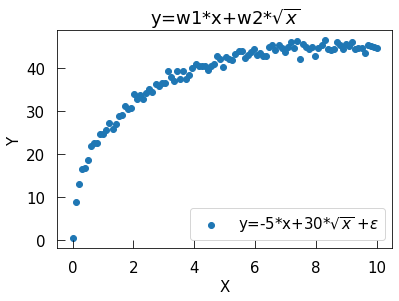

In [573]:
plt.rc("font", size=15)
plt.scatter(X,Y,label='y=-5*x+30*$\sqrt{x}$ +$\epsilon$')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(loc='best')
plt.title('y=w1*x+w2*$\sqrt{x}$')
plt.show()

In [574]:


a1=np.arange(-18,22,1) 
b1=np.arange(5,45,1) 

#a,b=np.meshgrid(a,b) # this useful function combines all possibles values for mu and sigma

def loglike_func(Y,X,a1,b1,alpha,reg):
    """returns a list of the loglikelihoods of mus and sigmas given data X"""
    ll = []
    for i in range(len(a1)):
        #ll.append( alpha*sum((Y-X*a[i]-b[i])**2) +(1-alpha)*(abs(a[i])**reg+abs(b[i])**reg))
        ll.append( alpha*sum([(Y[j]-X[j]*a1[i]-b1[i]*X[j]**0.5)**2 for j in range(len(X))]) +(1-alpha)*(abs(a1[i])**reg+abs(b1[i])**reg))
        #if math.isnan(ll[-1]) or ll[-1]>10000: 
            #ll[-1] = 10000 # we verify that no numerical error gave us an NaN or very small log value
    return ll

In [575]:



def make_meshgrid(x, y, n=100):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    n: number of intermediary points (optional)

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, n),
                         np.linspace(y_min, y_max, n))
    return xx, yy


def plot_contours(ax,Y,X,function, xx, yy,alphas,reg, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    function: a function
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    zs=np.array(
    function(Y,X,np.ravel(xx),np.ravel(yy),alphas,reg)
    )
   
    out = ax.contourf(xx, yy, zs.reshape(xx.shape), 100,**params)
    
    ma=zs.argmin()
    mam=[np.ravel(xx)[ma],np.ravel(yy)[ma]]
    
    return out,mam

<ipython-input-576-b99eae92fe96>:3: MatplotlibDeprecationWarning:

Passing the sharex parameter of subplots() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.



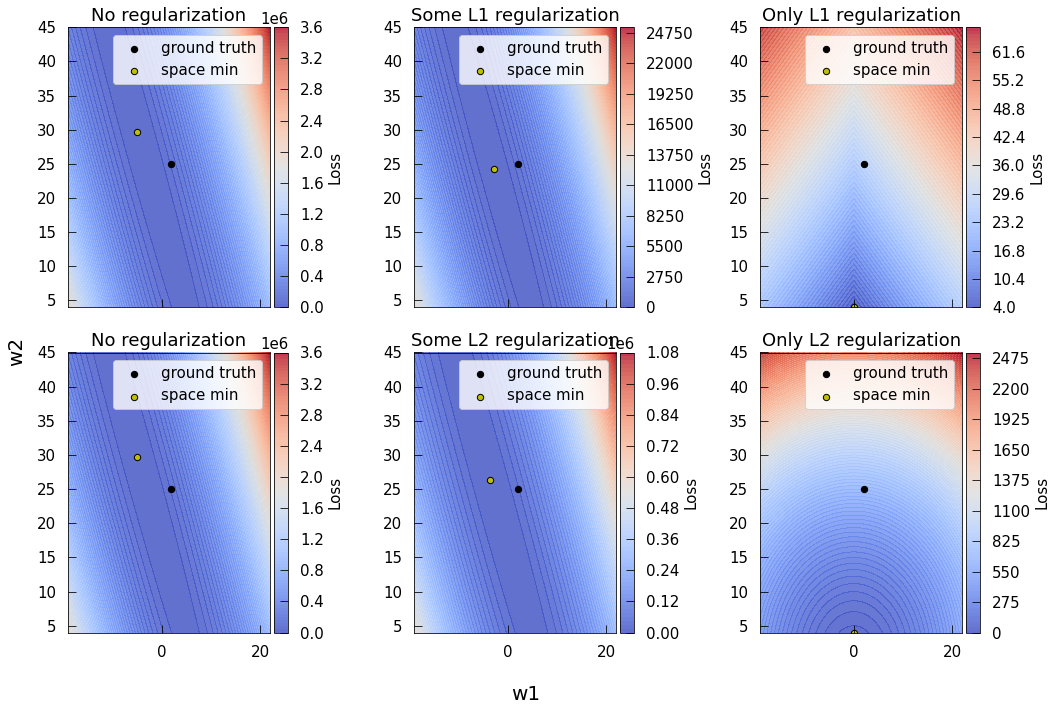

In [576]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

fig, ax = plt.subplots(2, 3,'all',figsize=(15,10))
        
xx, yy = make_meshgrid(a1, b1 , n=100)



graph,ma=plot_contours(ax[0,0],Y,X,loglike_func, xx, yy,1,1,
                      cmap=plt.cm.coolwarm, alpha=0.8)
ct=graph
ax[0,0].scatter(2, 25, c='k', s=40, edgecolors='k',label='ground truth')
ax[0,0].scatter(ma[0], ma[1], c='y', s=40, edgecolors='k',label='space min')
ax[0,0].set_xlim(xx.min(), xx.max())
ax[0,0].set_ylim(yy.min(), yy.max())
ax1_divider = make_axes_locatable(ax[0,0])
ax[0,0].legend(loc='best')
cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
fig.colorbar(ct,label='Loss', cax=cax1,orientation='vertical')
ax[0,0].set_title('No regularization')

graph,ma=plot_contours(ax[0,1],Y,X,loglike_func, xx, yy,7*10**-3,1,
                      cmap=plt.cm.coolwarm, alpha=0.8)
ct=graph
ax[0,1].scatter(2, 25, c='k', s=40, edgecolors='k',label='ground truth')
ax[0,1].scatter(ma[0], ma[1], c='y', s=40, edgecolors='k',label='space min')
ax[0,1].set_xlim(xx.min(), xx.max())
ax[0,1].set_ylim(yy.min(), yy.max())
ax2_divider = make_axes_locatable(ax[0,1])
ax[0,1].legend(loc='best')
cax2 = ax2_divider.append_axes("right", size="7%", pad="2%")
fig.colorbar(ct,label='Loss', cax=cax2,orientation='vertical')
ax[0,1].set_title('Some L1 regularization')

graph,ma=plot_contours(ax[0,2],Y,X,loglike_func, xx, yy,0,1,
                      cmap=plt.cm.coolwarm, alpha=0.8)
ct=graph
ax[0,2].scatter(2, 25, c='k', s=40, edgecolors='k',label='ground truth')
ax[0,2].scatter(ma[0], ma[1], c='y', s=40, edgecolors='k',label='space min')
ax[0,2].set_xlim(xx.min(), xx.max())
ax[0,2].set_ylim(yy.min(), yy.max())
ax3_divider = make_axes_locatable(ax[0,2])
ax[0,2].legend(loc='best')
cax3 = ax3_divider.append_axes("right", size="7%", pad="2%")
fig.colorbar(ct,label='Loss', cax=cax3,orientation='vertical')
ax[0,2].set_title('Only L1 regularization')



graph,ma=plot_contours(ax[1,0],Y,X,loglike_func, xx, yy,1,2,
                      cmap=plt.cm.coolwarm, alpha=0.8)
ct=graph
ax[1,0].scatter(2, 25, c='k', s=40, edgecolors='k',label='ground truth')
ax[1,0].scatter(ma[0], ma[1], c='y', s=40, edgecolors='k',label='space min')
ax[1,0].set_xlim(xx.min(), xx.max())
ax[1,0].set_ylim(yy.min(), yy.max())
ax4_divider = make_axes_locatable(ax[1,0])
ax[1,0].legend(loc='best')
cax4 = ax4_divider.append_axes("right", size="7%", pad="2%")
fig.colorbar(ct,label='Loss', cax=cax4,orientation='vertical')
ax[1,0].set_title('No regularization')

graph,ma=plot_contours(ax[1,1],Y,X,loglike_func, xx, yy,3*10**-1,2,
                      cmap=plt.cm.coolwarm, alpha=0.8)
ct=graph
ax[1,1].scatter(2, 25, c='k', s=40, edgecolors='k',label='ground truth')
ax[1,1].scatter(ma[0], ma[1], c='y', s=40, edgecolors='k',label='space min')
ax[1,1].set_xlim(xx.min(), xx.max())
ax[1,1].set_ylim(yy.min(), yy.max())
ax5_divider = make_axes_locatable(ax[1,1])
ax[1,1].legend(loc='best')
cax5 = ax5_divider.append_axes("right", size="7%", pad="2%")
fig.colorbar(ct,label='Loss', cax=cax5,orientation='vertical')
ax[1,1].set_title('Some L2 regularization')

graph,ma=plot_contours(ax[1,2],Y,X,loglike_func, xx, yy,0,2,
                      cmap=plt.cm.coolwarm, alpha=0.8)
ct=graph
ax[1,2].scatter(2, 25, c='k', s=40, edgecolors='k',label='ground truth')
ax[1,2].scatter(ma[0], ma[1], c='y', s=40, edgecolors='k',label='space min')
ax[1,2].set_xlim(xx.min(), xx.max())
ax[1,2].set_ylim(yy.min(), yy.max())
ax6_divider = make_axes_locatable(ax[1,2])
ax[1,2].legend(loc='best')
cax6 = ax6_divider.append_axes("right", size="7%", pad="2%")
fig.colorbar(ct,label='Loss', cax=cax6,orientation='vertical')
ax[1,2].set_title('Only L2 regularization')

fig.supxlabel('w1',fontsize=20)
fig.supylabel('w2',fontsize=20)

plt.tight_layout()
plt.show()